<a href="https://colab.research.google.com/github/fle1scha/DL4NTP/blob/main/DL4NTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add all imports and print TensorFlow version to verify it is correct version

In [46]:

import tensorflow as tf
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import datetime as dt

from datetime import datetime, date
import keras.backend as K
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers  import LSTM
from tensorflow.keras.layers  import TimeDistributed
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array
from numpy import cumsum
from pandas.tseries.holiday import USFederalHolidayCalendar
from random import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

print(keras.__version__)


2.6.0


# Read in Data

1. Mount Google Drive file system

In [47]:
# from google.colab import drive # Hosting the file in Google Drive, need to mount the drive so it is accessible
# # Currently Google forces an authorisation code, local runtime would rectify this
# drive.mount('/content/gdrive', force_remount=True) #force_remount forces Google t

In [48]:
#Read in SANREN dataset.
with open('SANREN_large.txt') as f:
  SANReN = f.readlines()

# ***Data Preprocessing***

In [49]:
#Clean dataframe headers and create labels.
headings_line = SANReN[0].split()

headings_line[4:7] = [''.join(headings_line[4:7])] #Merge 'Src', 'IP', and 'Addr:Port' 
headings_line[5:8] = [''.join(headings_line[5:8])] #Merge 'Dst', 'IP', and 'Addr:Port' 
headings_line = headings_line[0:6] + headings_line[8:13] #Remove 'Flags', 'Tos', and 'Flows'.

print(headings_line)

['Date', 'first-seen', 'Duration', 'Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp']


In [50]:
#Clean time-series data points. 
framedata = []
for i in range(1, 20001):
  data_line = SANReN[i].split()
  #print(headings_line)
  #sprint(data_line)
  #print(data_line)
  measures = ['M', 'G']
  if ((data_line[11] == "M" or data_line[11] == 'G') and (data_line[13] == 'M' or data_line[13] == 'G') and (data_line[15] == 'M' or data_line[15] == 'G')):
    if (data_line[11] == 'G'):
      data_line[10] = float(data_line[10])*100000000
    else:
      data_line[10] = float(data_line[10])*1000000\

    if (data_line[13] == 'G'):
      data_line[12] = float(data_line[12])*100000000
    else:
      data_line[12] = float(data_line[12])*1000000

    if (data_line[15] == 'G'):
      data_line[14] = float(data_line[14])*100000000
    else:
      data_line[14] = float(data_line[14])*1000000
    

    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:13] + data_line[14:15] + data_line[16:17]
    #print(data_line)

  elif ((data_line[11] == "M" or data_line[11] == 'G') and (data_line[14] == 'M' or data_line[14] == 'G')): #Bytes and BPS in megabytes\n"
    #print("1 and 2") 
    if (data_line[11] == 'G'):
      data_line[10] = float(data_line[10])*100000000
    else:
      data_line[10] = float(data_line[10])*1000000\

    if (data_line[14] == 'G'):
      data_line[13] = float(data_line[13])*100000000
    else:
      data_line[13] = float(data_line[13])*1000000
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:14] + data_line[15:16]
  
  elif ((data_line[12] == "M" or data_line[12] == 'G') and (data_line[12] == 'M' or data_line[12] == 'G')): #Bytes and BPS in megabytes\n"
    #print("1 and 2") 
    if (data_line[12] == 'G'):
      data_line[11] = float(data_line[11])*100000000
    else:
      data_line[11] = float(data_line[11])*1000000\

    if (data_line[14] == 'G'):
      data_line[13] = float(data_line[13])*100000000
    else:
      data_line[13] = float(data_line[13])*1000000
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:12] + data_line[13:14] + data_line[15:16]
     
  elif (data_line[13] == 'M' or data_line[13] == 'G'): #BPS measured in megabytes
    #print("2")
    if (data_line[13] == 'G'):
      data_line[12] = float(data_line[12])*100000000
    
    else:
      data_line[12] = float(data_line[12])*1000000
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:13] + data_line[14:15]
  
  elif data_line[11] == 'M': #Bytes measured in megabytes
    #print("1")
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:15]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    
  else: #No megabyte metrics
    #print("0")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:14]
   

  #data_line  = np.asarray(data_line) #Turn each line into a NumPy array.
  framedata.append(data_line) #append each line to 'mother' array.

In [51]:
#Convert Numpy array into Pandas dataframe.
df = pd.DataFrame(np.array(framedata), columns=headings_line) 
print(df.shape)

(20000, 11)


In [52]:
#Define all data types correctly. 
df['Datetimetemp'] = df['Date'] + 'T' + df['first-seen'] #Combine Date and first-seen
df = df.astype({'Date': 'datetime64[ns]'})
df["Day"] = df['Date'].dt.dayofweek #Created Day variable.
#df['Date'] = df['Date'].map(dt.datetime.toordinal)
df = df.astype({'first-seen': np.datetime64})
df = df.astype({'Duration': np.float64})
df = df.astype({"SrcIPAddr:Port": str})
df = df.astype({"DstIPAddr:Port": str})
df = df.astype({"Packets": np.int64})
df = df.astype({"Bytes": np.float64})
df = df.astype({"pps": np.float64})
df = df.astype({"bps": np.float64})
df = df.astype({"Bpp": np.float64})

#Create binary Weekend variable.
df['Weekend'] = 0
df.loc[df['Day'] == 5 , 'Weekend'] = 1
df.loc[df['Day'] == 6 , 'Weekend'] = 1

#Insert combined Datetime at front of dataframe.
df.insert(0, 'Datetime', df['Datetimetemp'])
df['Datetime'] = df.Datetime.astype('datetime64[ns]')
df['Datetime'] = df.Datetime.astype('int64') #Convert Datetime into an integer representation. This is a deprecated method. 

#Define university holiday calender
holidays = pd.date_range(start='2020-1-1', end='2020-3-14', freq = '1D')
holidays = holidays.append(pd.date_range(start='2020-5-1', end='2020-5-9', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-07-08', end='2020-08-02', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-09-18', end='2020-09-27', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-11-24', end='2020-12-31', freq='1D'))
#sprint(df['Date'])
#Add Holiday column to dataframe.
df['Holiday'] = 0
df.loc[(df['Date']) == any(holidays.date), 'Holiday'] = 1 #Can't get this to work



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


In [53]:
#Delete unused columns.
del df['Date']
del df['first-seen']
del df['Datetimetemp']

In [54]:
#One-Hot Encoding
category_df = (df.copy().drop(['Day', 'Weekend', 'Holiday', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Datetime', 'Duration', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp'], axis = 1))
for x in category_df.columns:
    #Printing unique values per categorical variable
    print(x ,':', len(category_df[x].unique()))

encoder = OneHotEncoder(sparse=False)
#Transform data
onehot = encoder.fit_transform(category_df)
category_df = pd.DataFrame(np.array(onehot))


Proto : 5


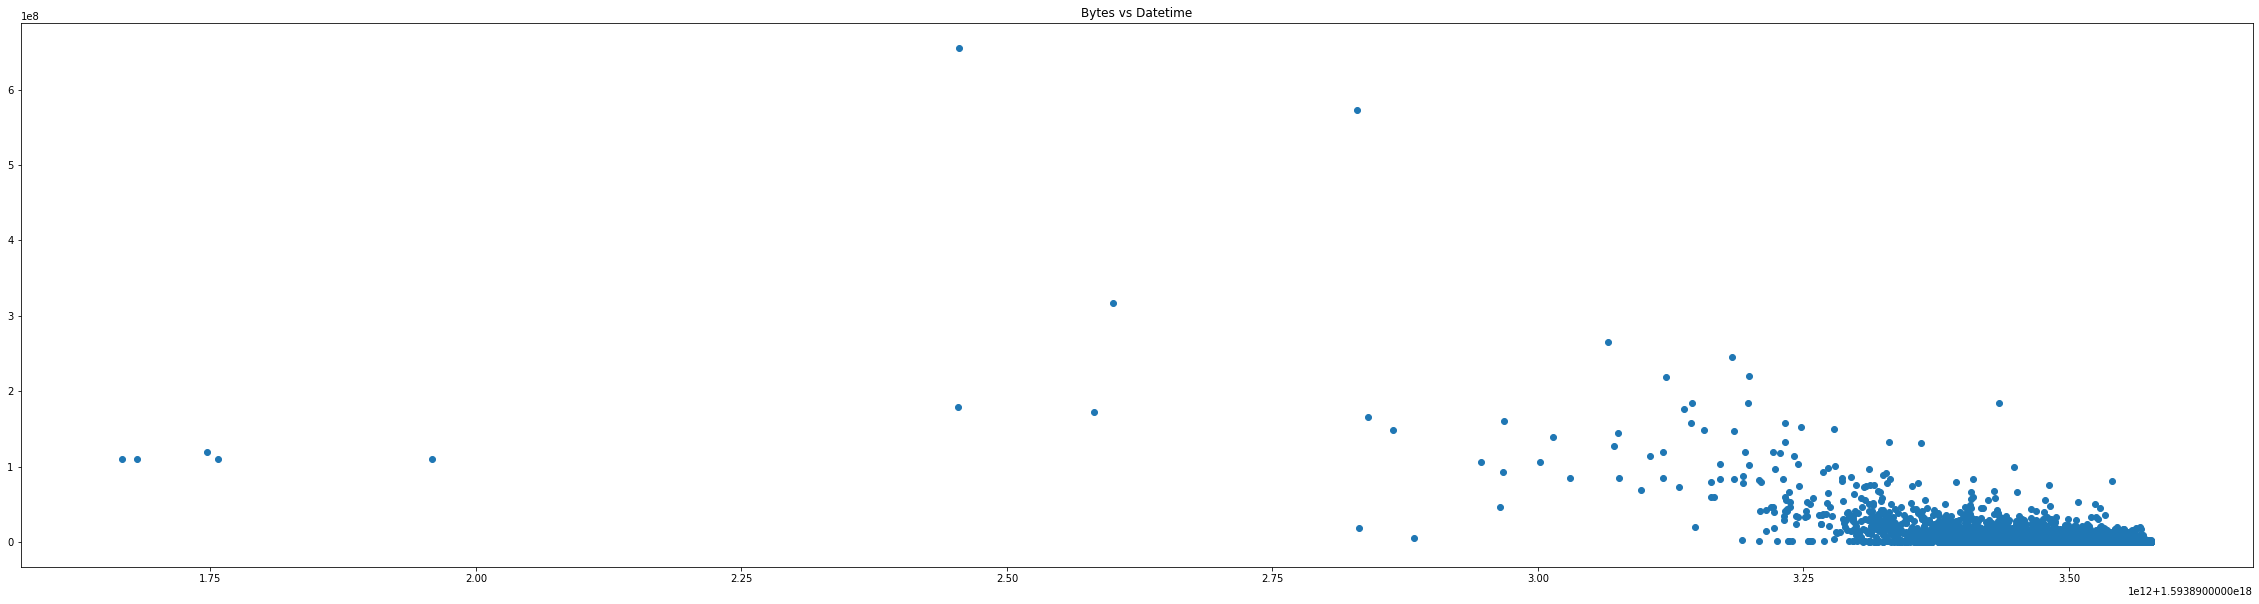

In [55]:
#A plot of Bytes vs Datetime
plt.figure(figsize=(40,10))
plt.title("Bytes vs Datetime")
plt.scatter(df['Datetime'], df['Bytes']) #changed to scatter because line graph is very bunched. fromordinal only differentiates by date so will have to find a way to get it into seconds. 


In [56]:
#Add encoded categorical data to regression data
df = (df.copy().drop(['SrcIPAddr:Port', 'DstIPAddr:Port', 'Proto'], axis = 1)).copy()
print(df.shape)
df = pd.concat([df, category_df], axis = 1)
print(df)

(20000, 10)
                  Datetime  Duration  Packets       Bytes      pps  \
0      1593893406480000000     1.223     4500    234000.0   3679.0   
1      1593893341555000000    78.205    31000  46500000.0    396.0   
2      1593893401690000000     5.307     1000     40000.0    188.0   
3      1593893363019000000    43.982     2000   3000000.0     45.0   
4      1593893407007000000     0.000      500    750000.0      0.0   
...                    ...       ...      ...         ...      ...   
19995  1593893566871000000    10.526    14000  20300000.0   1330.0   
19996  1593893577399000000     0.000      500    750000.0      0.0   
19997  1593893577418000000     0.000      500     35500.0      0.0   
19998  1593893576903000000     0.535     1500     78000.0   2803.0   
19999  1593893577452000000     0.092     1000   1400000.0  10869.0   

               bps     Bpp  Day  Weekend  Holiday    0    1    2    3    4  
0        1500000.0    52.0    5        1        0  0.0  0.0  1.0  0.0 

In [57]:
#Split data into both training and test set. Use 80/20 split.
test_size = int(len(df) * 0.2) # the test data will be 20% (0.2) of the sample.
train = df.iloc[:-test_size,:].copy()  #Not copying here threw an error. Must be careful not to keep two copies for memory reasons.
test = df.iloc[-test_size:,:].copy() 

X_train = train.drop('Bytes',axis=1).copy() #Drop target variable from training data. 
y_train = train[['Bytes']].copy() # The double brackets are to keep Bytes in a pandas dataframe format, otherwise it will be pandas Series.
print(X_train.shape, y_train.shape) #Check shape of training variables. 

(16000, 14) (16000, 1)


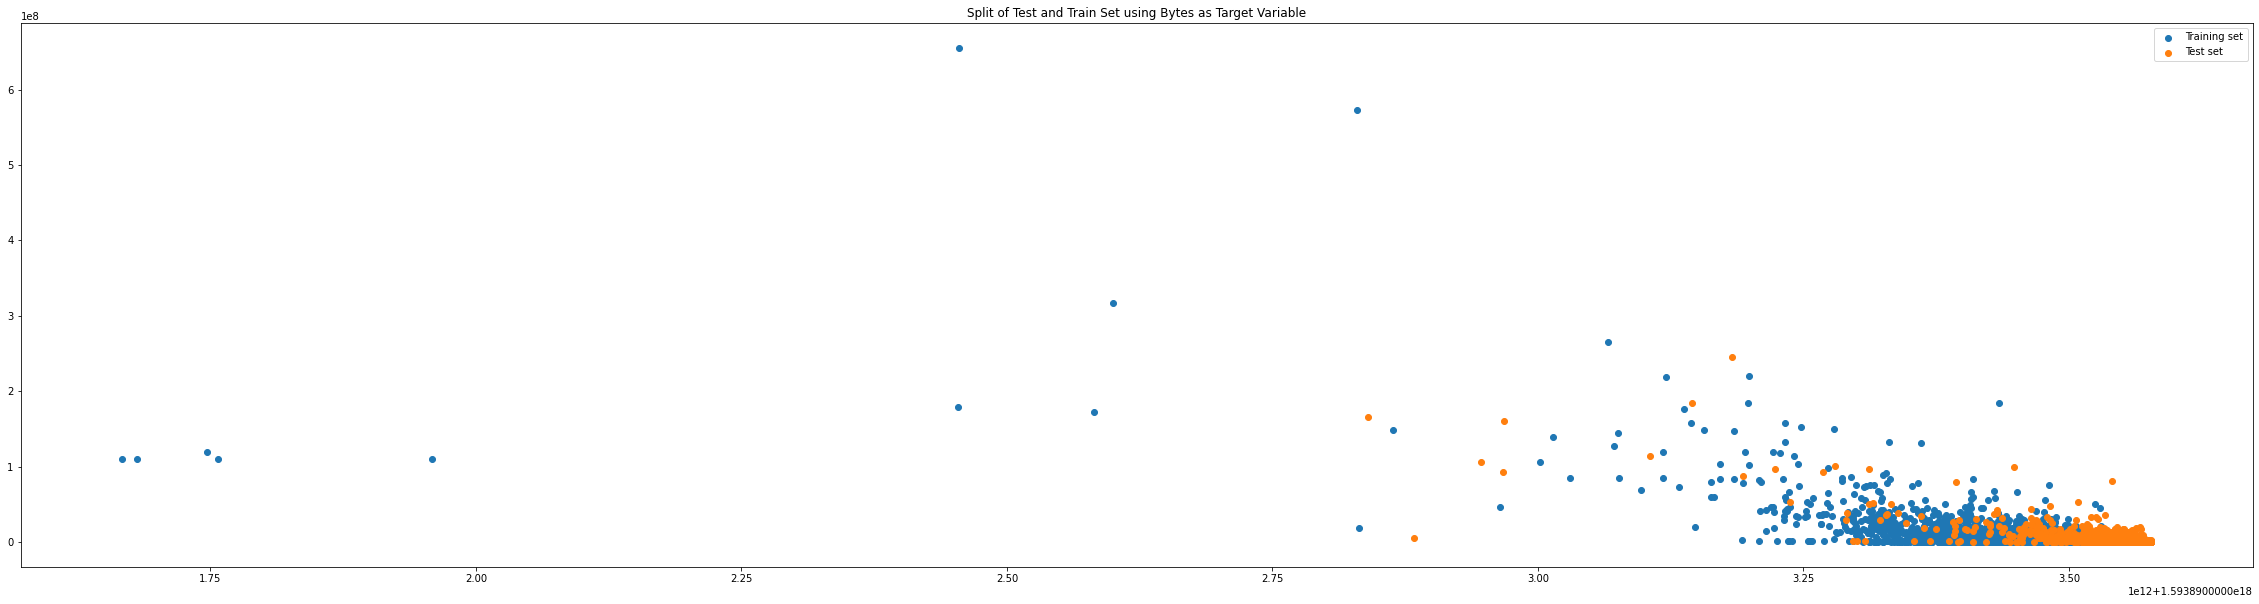

In [58]:
#Visualise split in sample
plt.figure(figsize=(40,10))
plt.title("Split of Test and Train Set using Bytes as Target Variable")
plt.scatter(train['Datetime'],train['Bytes'],label='Training set')
plt.scatter(test['Datetime'],test['Bytes'],label='Test set')
plt.legend()

In [59]:
#Scale training dating
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scikit MinMixScaler allows all variables to be normalised between 0 and 1.
Xscaler.fit(X_train) #Compute the minimum and maximum to be used for later scaling
scaled_X_train = Xscaler.transform(X_train) #Scale features of X according to feature_range.

print(X_train.shape) #X_train shape is the same as earlier but now scaled. 
print(scaled_X_train) #Demonstrate normalised data. 

(16000, 14)
[[9.27768433e-01 6.79508620e-04 4.87507617e-03 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.93144020e-01 4.34513260e-02 3.71724558e-02 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.25213933e-01 2.94861181e-03 6.09384522e-04 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.95182713e-01 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.95197112e-01 3.22252657e-05 6.09384522e-04 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.95244043e-01 9.47867299e-04 6.09384522e-04 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [60]:
#Scale training response
Yscaler = MinMaxScaler(feature_range=(0, 1)) #apply same normalisation to response. 
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

print(scaled_y_train.shape) #Shape is constant. 

(16000,)


In [61]:
#Define input_shape for LSTM
n_input = 100 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 100 # Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
print(train_generator[0][0].shape)

(100, 100, 14)


In [62]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Simple LSTM Implementation

In [63]:
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
simple_LSTM_model = Sequential() 
# Model is an LSTM, 50 is dimentionality of the output, activation function is relu
simple_LSTM_model.add(LSTM(50, activation='sigmoid', input_shape=(n_input, n_features))) 
# Dense layer as the first layer of the model
simple_LSTM_model.add(Dense(1)) 
# Compile the model with the adam optimizer, loss measured in Mean Squarred Error
# Adam refers to the learning rate change, which is measured by the exponentially decaying average of past gradients
simple_LSTM_model.compile(optimizer='adam', loss=rmse) 
# Print out a summary of the LSTM to check that it was compiled correctly 
simple_LSTM_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
159/159 [==============================] - 10s 55ms/step - loss: 0.0101
Epoch 2/5
159/159 [==============================] - 12s 76ms/step - loss: 0.0080
Epoch 3/5
159/159 [==============================] - 10s 61ms/step - loss: 0.0067
Epoch 4/5
159/159 [==============================] - 10s 64ms/step - loss: 0.0057
Epoch 5/5
159/159 [==============================] - 10s 61ms/step - loss: 0.0053


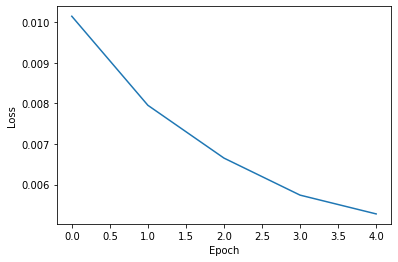

In [64]:
#Fit the data to the model and train.
simple_LSTM_model.fit(train_generator, epochs=5, verbose = 1) # Fit the features excluding target, and predict the target value
# verbose of 0 hides the training, 2 shows the full log
loss_per_epoch = simple_LSTM_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [65]:
#Testing x data
X_test = test.drop('Bytes', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=100, batch_size=b_size) #There are only 17 samples in the test set so it cannot look back.
print(test_generator[0][0].shape)

(100, 100, 14)


          y_true        y_pred
0       724000.0 -1.753035e+05
1       700000.0 -1.207310e+06
2       750000.0 -1.509272e+06
3        20000.0 -1.606096e+06
4        26000.0 -3.120906e+06
...          ...           ...
3895  20300000.0 -1.387842e+06
3896    750000.0  3.735023e+06
3897     35500.0 -5.086145e+05
3898     78000.0 -1.493096e+06
3899   1400000.0 -1.761576e+06

[3900 rows x 2 columns]


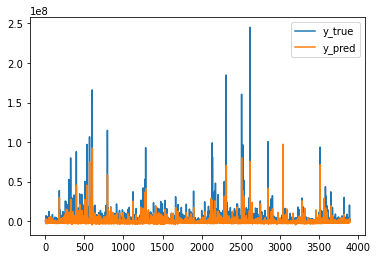

In [66]:
#Predicted LSTM response for bytes
y_pred_scaled = simple_LSTM_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
simple_lstm_results.plot()
print(simple_lstm_results)

In [67]:
#Predicted  LSTM response in megabytes
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
simple_lstm_results['residuals'] = np.square(
    simple_lstm_results.y_pred - simple_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
simple_LSTM_mse = simple_lstm_results.residuals.sum() * (1/len(simple_lstm_results))
print('RMSE: ' + str(np.round(rmse(simple_lstm_results.y_true, simple_lstm_results.y_pred), 3)))
print('MSE: ' + str(np.round(simple_LSTM_mse, 3)))
print('MAE: ' + str(mean_absolute_error(simple_lstm_results.y_true, simple_lstm_results.y_pred)))


RMSE: 10.787
MSE: 116.365
MAE: 4.495591824594382


In [68]:
# LSTM Coefficient of Determination Measurement
simple_LSTM_correlation_matrix = np.corrcoef(simple_lstm_results.y_pred,
                          simple_lstm_results.y_true)
corr = simple_LSTM_correlation_matrix[0, 1]
simple_LSTM_R_sq = corr**2
print(np.round(simple_LSTM_R_sq, 5))


8e-05


# Bidirectional LSTM Implementation

In [69]:
# Bidirectional LSTM supported in Keras using a layer wrapper 
# Common approach is to use concatenate, providing 2x outputs to next layer
# Takes the first LSTM layer as an argument
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
bidirectional_lstm_model = Sequential() 
bidirectional_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False, activation="sigmoid"), input_shape=(n_input, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(loss=rmse, optimizer='adam')
bidirectional_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 100)               26000     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 26,101
Trainable params: 26,101
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
159/159 - 15s - loss: 0.0124
Epoch 2/5
159/159 - 13s - loss: 0.0086
Epoch 3/5
159/159 - 12s - loss: 0.0099
Epoch 4/5
159/159 - 12s - loss: 0.0105
Epoch 5/5
159/159 - 14s - loss: 0.0079


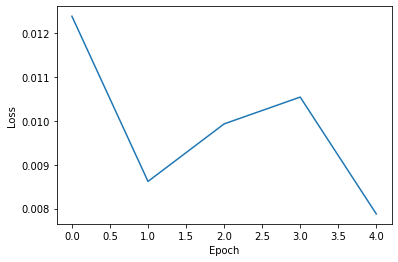

In [70]:
bidirectional_lstm_model.fit(train_generator, epochs=5, verbose=2)
loss_per_epoch = bidirectional_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

          y_true        y_pred
0       724000.0 -3.178254e+06
1       700000.0 -3.994862e+06
2       750000.0 -3.914681e+06
3        20000.0 -3.555026e+06
4        26000.0 -6.773220e+06
...          ...           ...
3895  20300000.0 -6.487786e+06
3896    750000.0  7.599808e+05
3897     35500.0 -4.738272e+06
3898     78000.0 -6.164660e+06
3899   1400000.0 -6.173084e+06

[3900 rows x 2 columns]


<AxesSubplot:>

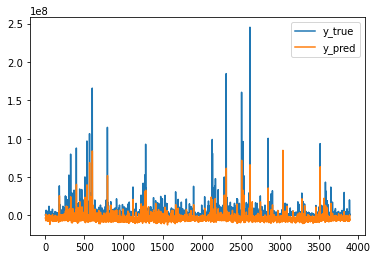

In [71]:
y_pred_scaled = bidirectional_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
print(bidirectional_lstm_results)
bidirectional_lstm_results.plot()

Predictions made in megabytes

In [72]:

bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
bidirectional_lstm_results['residuals'] = np.square(bidirectional_lstm_results.y_pred - bidirectional_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
bidirectional_LSTM_mse = bidirectional_lstm_results.residuals.sum() * (1/len(bidirectional_lstm_results))
print('RMSE: ' + str(np.round(rmse(bidirectional_lstm_results.y_true,
      bidirectional_lstm_results.y_pred), 3)))
print('MSE: ' + str(np.round(bidirectional_LSTM_mse, 3)))
print('MAE: ' + str(mean_absolute_error(bidirectional_lstm_results.y_true,
      bidirectional_lstm_results.y_pred)))


RMSE: 12.049
MSE: 145.185
MAE: 7.074317598212766


In [73]:
# LSTM Coefficient of Determination Measurement
bidirectional_LSTM_correlation_matrix = np.corrcoef(bidirectional_lstm_results.y_pred,
                                                    bidirectional_lstm_results.y_true)
corr = bidirectional_LSTM_correlation_matrix[0, 1]
bidirectional_LSTM_R_sq = corr**2
print(np.round(bidirectional_LSTM_R_sq, 5))

7e-05


# Stacked LSTM Implementation

In [74]:
stacked_lstm_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
stacked_lstm_model.add(LSTM(50, return_sequences=True, activation="sigmoid", input_shape=(n_input, n_features)))
stacked_lstm_model.add(LSTM(50, return_sequences=True))
stacked_lstm_model.add(LSTM(50))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(loss=rmse, optimizer='adam')
stacked_lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           13000     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 53,451
Trainable params: 53,451
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
159/159 [==============================] - 40s 215ms/step - loss: 0.0162
Epoch 2/5
159/159 [==============================] - 29s 185ms/step - loss: 0.0052
Epoch 3/5
159/159 [==============================] - 30s 186ms/step - loss: 0.0046
Epoch 4/5
159/159 [==============================] - 32s 201ms/step - loss: 0.0055
Epoch 5/5
159/159 [==============================] - 35s 222ms/step - loss: 0.0041


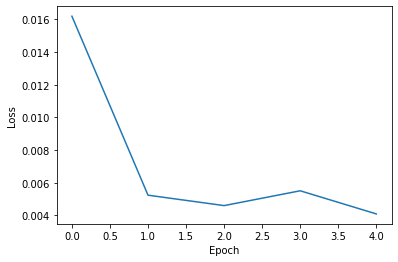

In [75]:
stacked_lstm_model.fit(train_generator, epochs=5, verbose=1)
loss_per_epoch = stacked_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

[[ 0.00123334]
 [ 0.00141223]
 [ 0.00139741]
 ...
 [ 0.00117575]
 [ 0.00035408]
 [-0.00054558]]
          y_true         y_pred
0       724000.0  824188.187500
1       700000.0  941408.625000
2       750000.0  931701.500000
3        20000.0  929531.187500
4        26000.0   24385.869141
...          ...            ...
3895  20300000.0   92778.812500
3896    750000.0  484820.281250
3897     35500.0  786453.000000
3898     78000.0  248021.281250
3899   1400000.0 -341511.343750

[3900 rows x 2 columns]


<AxesSubplot:>

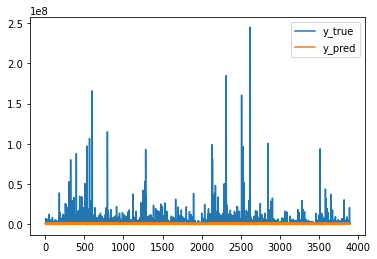

In [76]:
y_pred_scaled = stacked_lstm_model.predict(test_generator)
print(y_pred_scaled)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
stacked_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:], 'y_pred':y_pred.ravel()})
print(stacked_lstm_results)
stacked_lstm_results.plot()


Predictions made in megabytes

In [77]:
stacked_lstm_results = pd.DataFrame(
    {'y_true': test['Bytes'].values[100:]/1000000, 'y_pred': y_pred.ravel()/1000000})
stacked_lstm_results['residuals'] = np.square(
    stacked_lstm_results.y_pred - stacked_lstm_results.y_true)
stacked_LSTM_mse = stacked_lstm_results.residuals.sum() * \
    (1/len(stacked_lstm_results))
print('RMSE: ' + str(np.round(rmse(stacked_lstm_results.y_true,
      stacked_lstm_results.y_pred), 3)))
print('MSE: ' + str(np.round(stacked_LSTM_mse, 3)))
print('MAE: ' + str(mean_absolute_error(stacked_lstm_results.y_true,
      stacked_lstm_results.y_pred)))


RMSE: 9.371
MSE: 87.808
MAE: 2.5888863066817143


In [78]:
# LSTM Coefficient of Determination Measurement
simple_LSTM_correlation_matrix = np.corrcoef(simple_lstm_results.y_pred,
                          simple_lstm_results.y_true)
corr = simple_LSTM_correlation_matrix[0, 1]
simple_LSTM_R_sq = corr**2
print(np.round(simple_LSTM_R_sq, 5))

# LSTM Coefficient of Determination Measurement
bidirectional_LSTM_correlation_matrix = np.corrcoef(bidirectional_lstm_results.y_pred,
                                                    bidirectional_lstm_results.y_true)
corr = bidirectional_LSTM_correlation_matrix[0, 1]
bidirectional_LSTM_R_sq = corr**2
print(np.round(bidirectional_LSTM_R_sq, 5))

# LSTM Coefficient of Determination Measurement
stacked_LSTM_correlation_matrix = np.corrcoef(stacked_lstm_results.y_pred,
                                                    stacked_lstm_results.y_true)
corr = stacked_LSTM_correlation_matrix[0, 1]
stacked_LSTM_R_sq = corr**2
print(np.round(stacked_LSTM_R_sq, 5))

8e-05
7e-05
0.0


In [79]:
print('Mean Squared Errors on Test Sets in MB')
print('Bidirectional LSTM MSE: ' + str(np.round(bidirectional_LSTM_mse, 3)))
print('Simple LSTM MSE: ' + str(np.round(simple_LSTM_mse, 3)))
print('Stacked LSTM MSE: ' + str(np.round(stacked_LSTM_mse, 3)))

Mean Squared Errors on Test Sets in MB
Bidirectional LSTM MSE: 145.185
Simple LSTM MSE: 116.365
Stacked LSTM MSE: 87.808


Coefficient of Determination = R^2
- Regression error metric, evaluate the accuracy and efficiency of a model
- Describes the variation in response or target variable which is predicted by independent variables of the data model